#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import time
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.tail(10)

,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


проверим хронологический порядок:

In [5]:
df.index.is_monotonic

True

ресэмплируем по часу:

In [6]:
df = df.resample('1H').sum()

проверим наличие пропусков:

In [7]:
df.isnull().sum()

num_orders    0
dtype: int64

проверим дубликаты:

In [8]:
df.duplicated().sum()

4165

In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Построим график распределения:

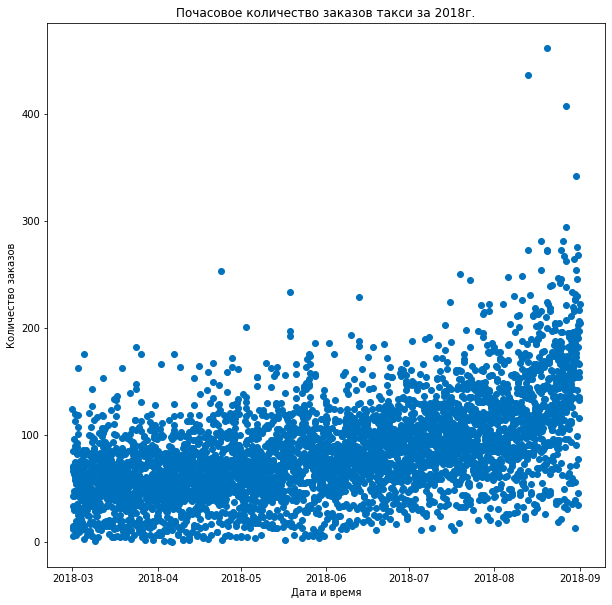

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.index.values,
           df['num_orders'],
           color='#0072BD')
ax.set(xlabel="Дата и время",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за 2018г.")
plt.show()

### Вывод:

В датасете есть количество заказов за полгода 2018 года с марта по август включительно на каждый час. Набор данных всего содержит 26 496 строк и 1 столбец с количеством заказов такси.

- В данных нет пропущенных значений.

- В данных есть 4165 дубликатов, однако эти дубликаты могут являться следствием большого количества заказов такси примерно в одно время.

- График рассеяния показал что вне зависимости от времени большинство заказов приходится на промежуток от 0 до 100 заказов, однако ближе к сентябрю 2018 (2018-09), минимальное кол-во заказов увеличилось, а также видны необычные выбросы в данных.


## Анализ

Попробуем сгладить временной ряд:

In [11]:
df["rolling_mean"] = df["num_orders"].rolling(24).mean()
df["rolling_std"] = df["num_orders"].rolling(24).std()

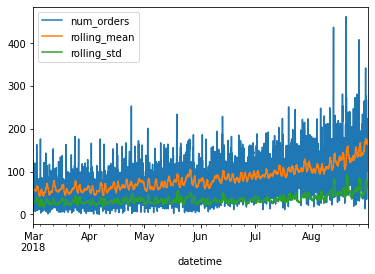

In [12]:
df.plot();

**Вывод:** Можно сказать, что наш ряд достаточно стационарен за исключением августовского хвоста.

Посмотрим, что будет если мы получим разность ряда:

In [13]:
df_new = df - df.shift()

In [14]:
df_new["rolling_mean"] = df_new["num_orders"].rolling(24).mean()
df_new["rolling_std"] = df_new["num_orders"].rolling(24).std()

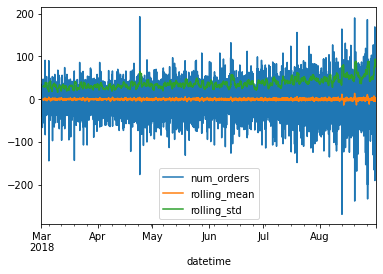

In [15]:
df_new.plot();

**Вывод:** Стационарный ряд.

Удалим все признаки, которые использовались для анализа и создадим новые, используя определенную ниже функцию:

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(df, 24, 24)

Построим графики тренда и сезонности:

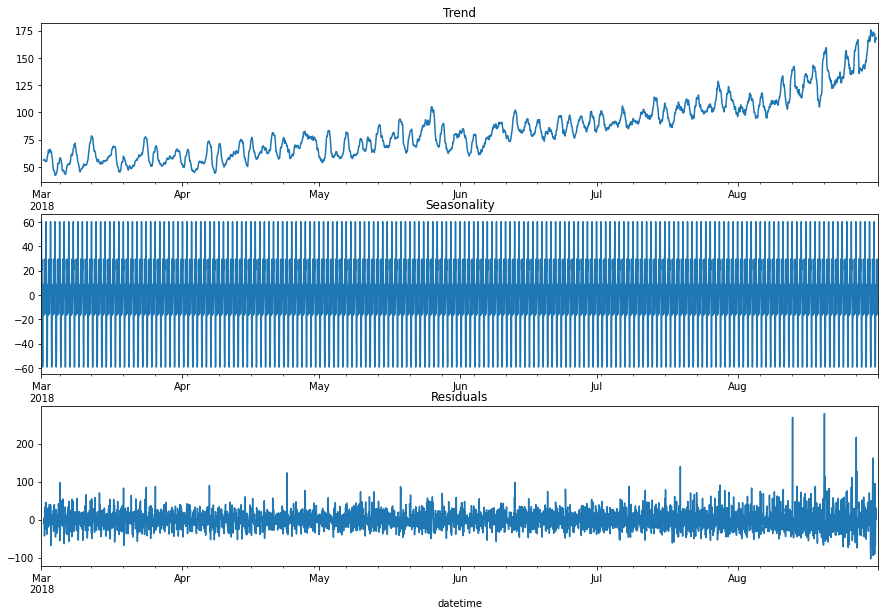

In [18]:
decomposed = seasonal_decompose(df["num_orders"]);
fig,ax = plt.subplots(3,1,figsize = (15,10))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals');

Возьмем два дня(например 10-е число) - один в августе, другой в марте и посмотрим на сезонность:

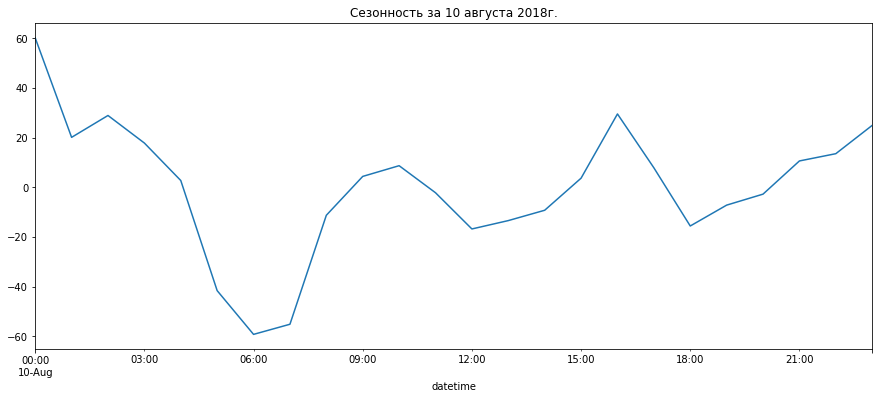

In [19]:
decomposed.seasonal['2018-08-10'].plot(figsize=(15, 6))
plt.title('Сезонность за 10 августа 2018г.');

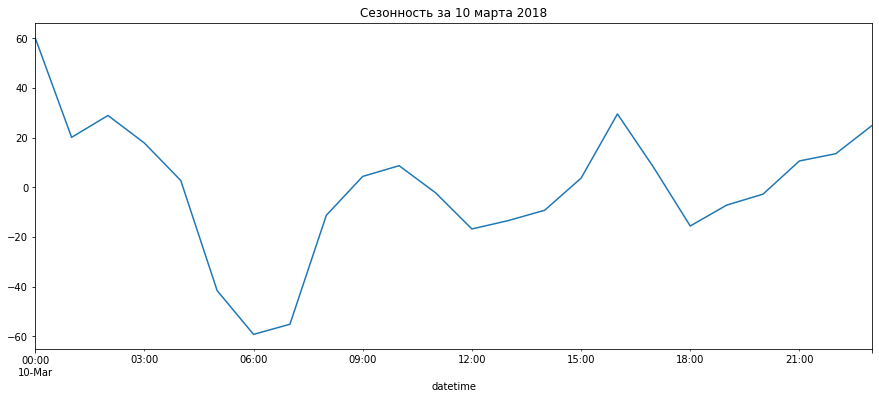

In [20]:
decomposed.seasonal['2018-03-10'].plot(figsize=(15, 6))
plt.title('Сезонность за 10 марта 2018');

**Вывод:** Графики идентичны. В начале каждого дня у нас пик, потом резкое падение, затем в течение дня количество заказов растет и к концу дня достигает нового пика.

## Обучение

Проведем разбиение данных на train, valid и test выборки. При работе с временными рядами перемешивать данные при разбиении на выборки нельзя.

In [21]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Создадим признаки для обучения моделей:

In [22]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Нам необходимо подобрать наиболее эффективную модель(наименьшая RMSE). Также отследим время обучения моделей. Мы обучим и проанализируем следующие модели:

- Linear Regression (Линейная регрессия)

- Random Forest (Случайный лес)

- Catboost

- LightGBM

- DecisionTree

Определим функцию для метрики:

In [23]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Используем гридсерч для подбора параметров:

In [24]:
# TimeSeriesSplit 
splits = TimeSeriesSplit(n_splits=8)
def best_model(model, params, features_train, target_train):
    grid = GridSearchCV(model, param_grid = params, cv=splits,
                                            scoring = RMSE_score, n_jobs=-1)
    grid.fit(features_train,target_train)
    results = pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')
    
    fit_time = results.iloc[0]['mean_fit_time']
    predict_time = results.iloc[0]['mean_score_time']
    return fit_time, predict_time, -grid.best_score_ , grid.best_params_,  

Лассо-модель:

In [25]:
lasso_model = Lasso(random_state=123)
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

In [26]:
lasso = best_model(lasso_model, lasso_params, features_train, target_train)

In [27]:
lasso

(0.26076287031173706, 0.11320081353187561, 26.688720747503655, {'alpha': 0.03})

LGBM-модель:

In [28]:
lgbm_params = {
    'n_estimators': [10,50],
    'learning_rate': [0.4]
}
lgbm_reg_model = LGBMRegressor(random_state=123)

In [29]:
lgbm = best_model(lgbm_reg_model, lgbm_params, features_train, target_train)

In [30]:
lgbm

(23.933183044195175,
 0.051365822553634644,
 25.17711671129735,
 {'learning_rate': 0.4, 'n_estimators': 10})

Catboost:

In [31]:
catboost_params = {
    'learning_rate': [0.1,0.2],
    'iterations': [10,50,100],
    'max_depth': [10,20]}
catboost_model = CatBoostRegressor(random_state=123,silent=True)

In [ ]:
CatBoost = best_model(catboost_model, catboost_params, features_train, target_train)

In [ ]:
CatBoost

Случайный лес:

In [ ]:
RF_model = RandomForestRegressor(random_state=123)
forestregressor_params = {'n_estimators':range(10, 21, 10),
             'max_depth':range (1,10)}

In [ ]:
RandomForest = best_model(RF_model, forestregressor_params, features_train, target_train)

In [ ]:
RandomForest

Дерево решений:

In [ ]:
DT_model = DecisionTreeRegressor(random_state=123)
treeregressor_params = {'max_depth':range (1,10)}
DecisionTrees = best_model(DT_model, treeregressor_params, features_train, target_train)

In [ ]:
DecisionTrees

Константная модель:

In [ ]:
constant_model = DummyRegressor(strategy='mean')

In [ ]:
constant_model.fit(features_train,target_train)
constant_pred = constant_model.predict(features_test)
RMSE(target_test,constant_pred)

Сравним характеристики моделей:

In [ ]:
Models = pd.DataFrame([lasso, lgbm, CatBoost, RandomForest, DecisionTrees], 
             columns=['Время обучения', 'Время предсказания', 'RMSE на train', 'Лучшие Параметры'], 
                      index=['Lasso','LGBM','CatBoost', 'RandomForest', 'DecisionTrees'])

In [ ]:
Models

**Вывод**: На обучающей выборке у всех моделей примерно один результат. Для тестирования выберем CatBoost: она самая точная модель.

## Тестирование

In [28]:
Catboost = CatBoostRegressor(random_state=123,silent=True, iterations=100, learning_rate=0.2, max_depth=10)

In [29]:
Catboost.fit(features_train, target_train);

In [30]:
predictions = Catboost.predict(features_test)

In [31]:
Rmse = RMSE(target_test, predictions)

In [32]:
Rmse

45.83091329763325

In [33]:
preds_test = pd.Series(Catboost.predict(features_test), index = target_test.index, name='preds')

In [34]:
df_preds = pd.concat([target_test, preds_test], axis=1)

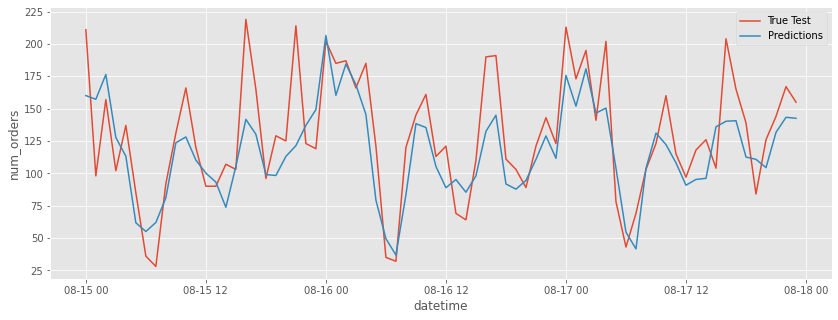

In [35]:
plt.figure(figsize=(14, 5));
plt.style.use('ggplot')
df = df_preds['2018-08-15':'2018-08-17']
sns.lineplot(x=df.index, y=df['num_orders'], label='True Test');
sns.lineplot(x=df.index, y=df['preds'], label='Predictions');

**Вывод:** Целевой показатель метрики преодолен, советуем Catboost-модель заказчику.

### Общий Вывод:

1) Исходный датасет был изучен. Пропуски не обнаружены, дубликаты оставлены из-за того, что у нас всего один признак.

2) Изучены стационарность ряда, сезонность и тренды наших данных.

3) Датасет разделен на обучающую и тестовую выборки. На этих данных обучены модели Lasso, Lgbm, CatBoost, RandomForest и DecisionTree.

4)  Отобрана лучшая модель - CatBoost, на тестовой выборке она показала  47.4, Рекомендуем ее заказчику за счет быстрого времени обучения и высокой точности.